In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor, plot_importance
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats


# Load Data

In [2]:
df = pd.read_csv('data/data_be.csv')
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
df.drop('date', axis=1, inplace=True)
df


,price,ActualLoad,ForecastLoad,weekday,season,period
date,,,,,,
2020-01-01 00:00:00,38.60,8700.50,8544.00,Wednesday,winter,night
2020-01-01 01:00:00,36.55,8320.25,8185.75,Wednesday,winter,night
2020-01-01 02:00:00,32.32,8000.75,7896.75,Wednesday,winter,night
2020-01-01 03:00:00,30.85,7795.50,7720.50,Wednesday,winter,night
2020-01-01 04:00:00,30.14,7784.00,7660.25,Wednesday,winter,night
...,...,...,...,...,...,...
2022-12-31 19:00:00,-32.27,8171.75,9171.00,Saturday,winter,evening
2022-12-31 20:00:00,6.20,7846.25,8592.75,Saturday,winter,evening
2022-12-31 21:00:00,35.96,7794.00,8693.50,Saturday,winter,evening


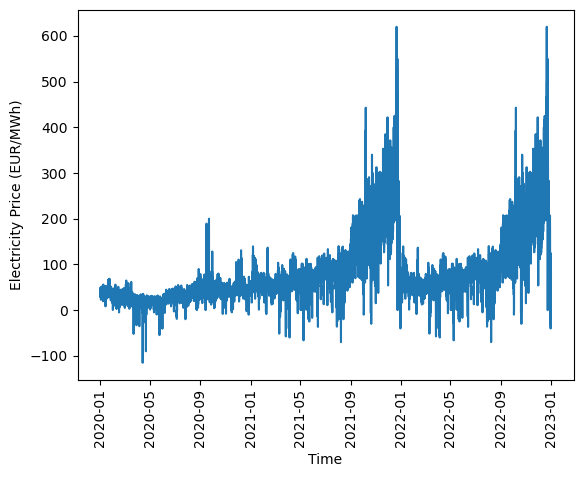

In [3]:
# Plot of Electricity Prices
plt.plot(df.index, df['price'])
plt.xticks(rotation =90)
plt.xlabel('Time')
plt.ylabel('Electricity Price (EUR/MWh)')
plt.show()

# Exploratory Analysis

In [4]:
# season
ave_season = df.groupby('season')['price'].mean()
var_season = df.groupby('season')['price'].var()

result_season = pd.DataFrame({'Mean': ave_season, 'Variance': var_season})
print(result_season)


#weekday
ave_weekday = df.groupby('weekday')['price'].mean()
var_weekday = df.groupby('weekday')['price'].var()

result_weekday = pd.DataFrame({'Mean': ave_weekday, 'Variance': var_weekday})
print(result_weekday)

# period of a day
ave_period = df.groupby('period')['price'].mean()
var_period = df.groupby('period')['price'].var()

result_period = pd.DataFrame({'Mean': ave_period, 'Variance': var_period})
print(result_period)


              Mean     Variance
season                         
fall    125.632292  6190.167236
spring   41.390931   732.724893
summer   61.576374  1016.430495
winter   92.113810  9941.615324
                Mean     Variance
weekday                          
Friday     84.607866  5963.699460
Monday     74.243619  4838.532505
Saturday   75.688692  4903.787460
Sunday     65.598793  4206.301318
Thursday   87.285613  6108.972705
Tuesday    85.535142  5919.966748
Wednesday  86.943538  5839.245898
                Mean     Variance
period                           
afternoon  84.711384  7123.943276
evening    84.167901  4750.136004
morning    84.630654  6191.086537
night      66.487997  3517.367871


# Data Preprocessing


In [5]:
# Data Preprocessing - to track the data several lags ahead
for i in range(3):
    df['price_d{}'.format(i+1)] = df['price'].shift((i+1)*24)

df['price_d{}'.format(7)] = df['price'].shift(7*24)

for i in range(3):
    df['ActualLoad_d{}'.format(i+1)] = df['ActualLoad'].shift((i+1)*24)

df['ActualLoad_d{}'.format(7)] = df['ActualLoad'].shift(7*24)

df.dropna(inplace=True)

In [6]:
# One-hot Encoding for categorical feature
data = df.drop('ActualLoad',axis=1)
data = pd.get_dummies(data, columns = ['weekday', 'season','period'])

In [7]:
data

,price,ForecastLoad,price_d1,price_d2,price_d3,price_d7,ActualLoad_d1,ActualLoad_d2,ActualLoad_d3,ActualLoad_d7,...,weekday_Tuesday,weekday_Wednesday,season_fall,season_spring,season_summer,season_winter,period_afternoon,period_evening,period_morning,period_night
date,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00,27.28,9384.50,31.10,29.00,32.28,38.60,9475.50,8787.50,8725.00,8700.50,...,0,1,0,0,0,1,0,0,0,1
2020-01-08 01:00:00,24.60,9081.00,29.90,29.08,31.18,36.55,9183.75,8494.50,8400.25,8320.25,...,0,1,0,0,0,1,0,0,0,1
2020-01-08 02:00:00,20.86,8880.00,29.02,27.72,30.10,32.32,8877.75,8314.00,8202.00,8000.75,...,0,1,0,0,0,1,0,0,0,1
2020-01-08 03:00:00,19.36,8917.50,29.65,27.03,29.96,30.85,8967.25,8282.75,8141.25,7795.50,...,0,1,0,0,0,1,0,0,0,1
2020-01-08 04:00:00,25.00,9423.00,31.79,28.98,29.88,30.14,9450.50,8970.00,8184.00,7784.00,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,-32.27,9171.00,94.18,130.06,139.09,350.00,8831.75,9167.50,9126.75,8153.75,...,0,0,0,0,0,1,0,1,0,0
2022-12-31 20:00:00,6.20,8592.75,46.26,108.64,125.22,338.04,8468.25,8811.50,8750.75,7894.00,...,0,0,0,0,0,1,0,1,0,0
2022-12-31 21:00:00,35.96,8693.50,10.83,106.34,127.68,315.27,8496.75,8847.00,8646.75,7936.75,...,0,0,0,0,0,1,0,1,0,0


In [8]:
# Scaling continuous feature
X = data.drop('price',axis=1)
scaler_X = StandardScaler()
scaler_X.fit(X.iloc[:, 0:9])
X_scaled = X.copy()
X_scaled.iloc[:, 0:9] = scaler_X.transform(X.iloc[:, 0:9])
y = data['price']

scaler_y = StandardScaler()
scaler_y.fit(y.values.reshape(-1,1))
y_scaled = scaler_y.transform(y.values.reshape(-1,1))

In [29]:
# Parameter Tuning: Ramdom Search, XGBoost as an example
# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(5, 20),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.1),
    'n_estimators':stats.randint(200, 1500)
}

# Create the XGBoost model object
xgb_model = XGBRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_root_mean_squared_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_scaled, y)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.017568839538059936, 'max_depth': 17, 'n_estimators': 449, 'subsample': 0.5923796059852755}
Best score:  -21.888679463832418


In [9]:
# Model Training
preds = []
tests = []
y_indices = []
mymae = 0
myrmse = 0
mymase = 0
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_scaled):

    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #y_train, y_test = y_scaled.iloc[train_index], y_scaled.iloc[test_index]
    
    #regressor = SVR(kernel= 'rbf',C=2)
    #regressor = RandomForestRegressor(n_estimators = 1000, max_features = 0.3 , max_depth = 15, random_state = 18)
    #regressor = Lasso()
    #regressor = LinearRegression()
    #regressor =  Ridge()
    regressor = XGBRegressor(n_estimators=500, max_depth=18, learning_rate=0.02, subsample=0.6)
    regressor.fit(X_train,y_train)

    y_pred = regressor.predict(X_test)
    
    # Metrics
    mse = mean_squared_error( y_test , y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test-y_pred))
    mae_naive = np.mean(np.abs(y_test-X['price_d1'].iloc[test_index]))
    
    mymase = mymase + mae/mae_naive
    mymae = mymae + mae
    myrmse = rmse + myrmse
    preds.append(y_pred)
    tests.append(y_test)
    y_indices.append(y_test.index)
    
    print(f"Test score: {mae}")
    print(f'naive mae:{mae_naive}')

    #plot_importance(regressor,importance_type='gain')

print('*******************************')
print(f'ave mae:{mymae/5}')
print(f'ave rmse:{myrmse/5}')
print(f'ave mase:{mymase/5}')

Test score: 9.197961953460554
naive mae:17.89961361897475
Test score: 9.083523447270691
naive mae:17.731674000382625
Test score: 9.354493147517701
naive mae:18.013346087621965
Test score: 9.175311512698634
naive mae:18.39701740960398
Test score: 8.751840022091706
naive mae:17.669083604361965
*******************************
ave mae:9.112626016607859
ave rmse:16.084716814171426
ave mase:0.5079015847961712


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

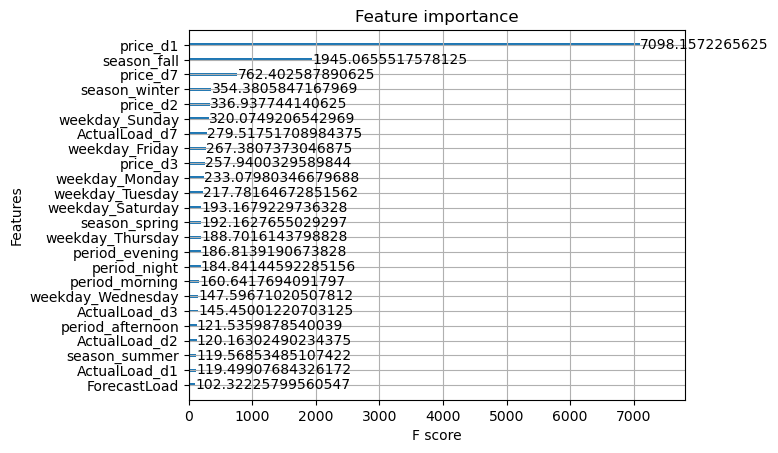

In [31]:
plot_importance(regressor,importance_type='gain')

Text(0.5, 0, 'Random Forest Feature Importance')

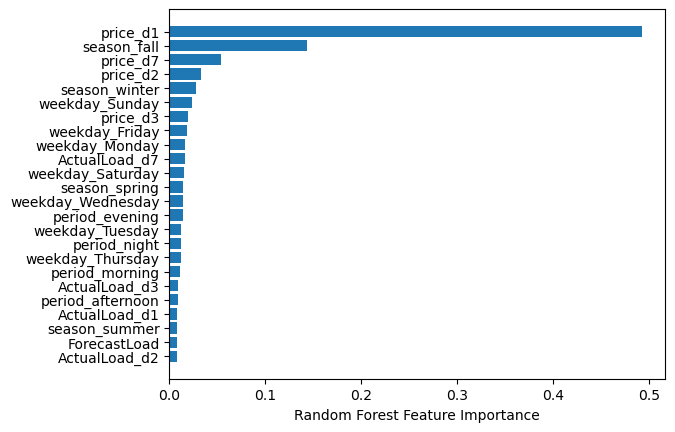

In [23]:
# random forest
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(regressor.feature_names_in_[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [12]:
## Prediction Examples
st_spring = data.index.get_loc('2022-04-16 00:00:00')
st_summer = data.index.get_loc('2022-08-16 00:00:00')
st_fall = data.index.get_loc('2022-11-02 00:00:00')
st_winter = data.index.get_loc('2021-12-29 00:00:00')

p = 24
spring_y = data.iloc[st_spring:st_spring+p,0]
spring_X = X_scaled[st_spring:st_spring+p]
spring_pred = regressor.predict(spring_X)
summer_y = data.iloc[st_summer:st_summer+p,0]
summer_X = X_scaled[st_summer:st_summer+p]
summer_pred = regressor.predict(summer_X)
fall_y = data.iloc[st_fall:st_fall+p,0]
fall_X = X_scaled[st_fall:st_fall+p]
fall_pred = regressor.predict(fall_X)
winter_y = data.iloc[st_winter:st_winter+p,0]
winter_X = X_scaled[st_winter:st_winter+p]
winter_pred = regressor.predict(winter_X)




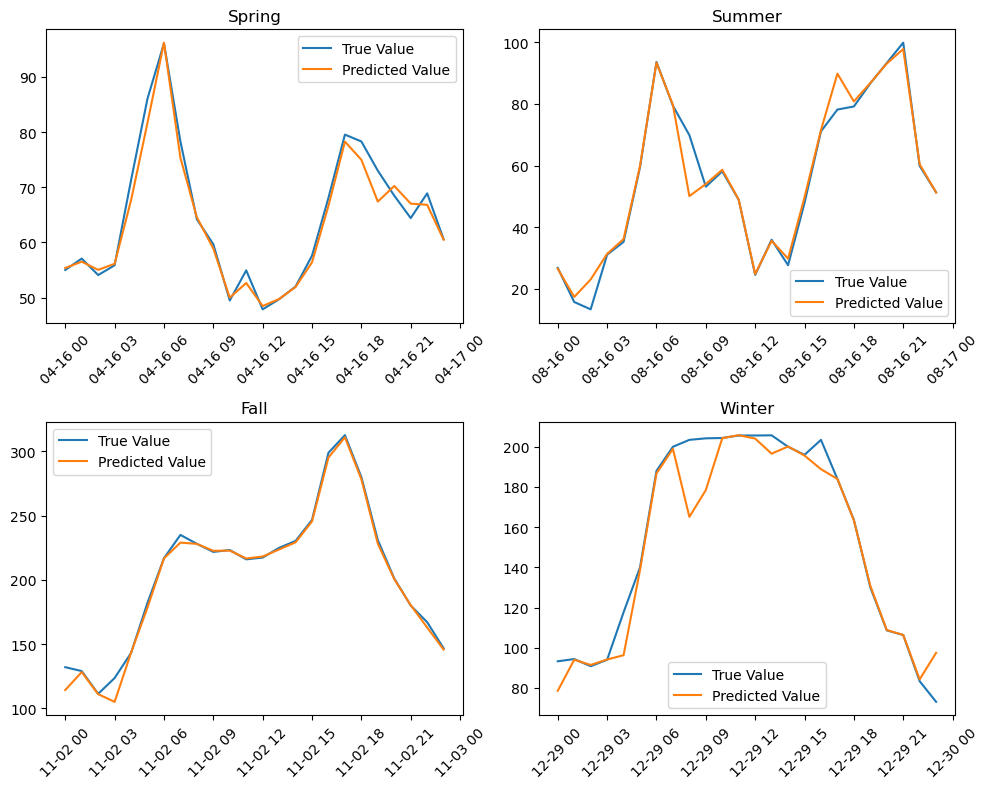

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot data on each subplot
axs[0, 0].plot(spring_y, label='True Value')
axs[0, 0].plot(spring_y.index,spring_pred, label='Predicted Value')
axs[0, 0].set_title('Spring')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

axs[0, 1].plot(summer_y, label='True Value')
axs[0, 1].plot(summer_y.index,summer_pred, label='Predicted Value')
axs[0, 1].set_title('Summer')
axs[0, 1].legend()
axs[0, 1].tick_params(axis='x', rotation=45)

axs[1, 0].plot(fall_y, label='True Value')
axs[1, 0].plot(fall_y.index,fall_pred, label='Predicted Value')
axs[1, 0].set_title('Fall')
axs[1, 0].legend()
axs[1, 0].tick_params(axis='x', rotation=45)

axs[1, 1].plot(winter_y, label='True Value')
axs[1, 1].plot(winter_y.index,winter_pred, label='Predicted Value')
axs[1, 1].set_title('Winter')
axs[1, 1].legend()
axs[1, 1].tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [24]:
# Performace details in different seasons, weekdays and periods of the day
test_output = pd.DataFrame({'true':y_test, 'pred':y_pred,'season':df.loc[y_test.index,'season'],'weekday':df.loc[y_test.index,'weekday'],'period':df.loc[y_test.index,'period'],'Priced1':df.loc[y_test.index,'price_d1']})
test_output['diff'] = test_output['true'] - test_output['pred']
test_output['naive'] = np.abs( test_output['true'] - test_output['Priced1'])

# season
avePred_season = test_output.groupby('season')['pred'].mean()
aveTrue_season = test_output.groupby('season')['true'].mean()
varPred_season = test_output.groupby('season')['pred'].var()
varTrue_season = test_output.groupby('season')['true'].var()
mae_season = test_output.groupby('season')['diff'].agg(lambda x: x.abs().mean())

result_season = pd.DataFrame({'PredMean': avePred_season, 'TrueMean':aveTrue_season, 'PredVar': varPred_season,'TrueVar':varTrue_season,'MAE':mae_season})
print(result_season)

#weekday
avePred_weekday = test_output.groupby('weekday')['pred'].mean()
aveTrue_weekday = test_output.groupby('weekday')['true'].mean()
varPred_weekday = test_output.groupby('weekday')['pred'].var()
varTrue_weekday = test_output.groupby('weekday')['true'].var()
mae_weekday = test_output.groupby('weekday')['diff'].agg(lambda x: x.abs().mean())

result_weekday = pd.DataFrame({'PredMean': avePred_weekday, 'TrueMean':aveTrue_weekday, 'PredVar': varPred_weekday,'TrueVar':varTrue_weekday,'MAE':mae_weekday})

print(result_weekday)

# period of a day
avePred_period = test_output.groupby('period')['pred'].mean()
aveTrue_period = test_output.groupby('period')['true'].mean()
varPred_period = test_output.groupby('period')['pred'].var()
varTrue_period = test_output.groupby('period')['true'].var()
mae_period = test_output.groupby('period')['diff'].agg(lambda x: x.abs().mean())

result_period = pd.DataFrame({'PredMean': avePred_period, 'TrueMean':aveTrue_period, 'PredVar': varPred_period,'TrueVar':varTrue_period,'MAE':mae_period})
print(result_period)

          PredMean    TrueMean      PredVar      TrueVar        MAE
season                                                             
fall    126.889320  127.789563  5491.665527  6282.231076  13.916734
spring   42.209869   42.628384   565.058472   700.771589   5.781569
summer   61.246857   61.149505   888.892761  1012.681113   5.725333
winter   91.625145   92.521604  8953.892578  9448.984303   9.458524
            PredMean   TrueMean      PredVar      TrueVar       MAE
weekday                                                            
Friday     88.233307  88.835026  5842.225098  6227.752474  9.042839
Monday     72.190170  71.081480  3796.102539  3854.294416  8.831574
Saturday   75.769958  76.394735  4535.851562  4973.258614  9.052486
Sunday     63.943943  63.778393  3896.112549  4100.066902  8.560883
Thursday   87.669197  88.086226  5196.016113  5694.699922  8.730690
Tuesday    86.036270  89.148081  5441.163086  6253.771289  8.072161
Wednesday  85.020782  85.362937  4978.087402  53

# Feedforward Neural Networks

In [6]:
# Scaling 
X = data.drop('price',axis=1)
scaler_X = MinMaxScaler()
scaler_X.fit(X.iloc[:, 0:9])
X_scaled = X.copy()
X_scaled.iloc[:, 0:9] = scaler_X.transform(X.iloc[:, 0:9])
y = data['price']

scaler_y = MinMaxScaler()
scaler_y.fit(y.values.reshape(-1,1))
y_scaled = scaler_y.transform(y.values.reshape(-1,1))

In [17]:
# Model Training
kf = KFold(n_splits=5, shuffle=True, random_state=42)
sum_mae = 0
sum_rmse = 0
sum_mase = 0
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Sequential()
    model.add(Dense(32, input_dim=X_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile the model with appropriate loss function and optimizer
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='loss', patience=5)

    # Train the model on the input data and output labels
    model.fit(X_train, y_train, epochs=300, batch_size=64,verbose=0,callbacks=[early_stopping])

    # Use the model to make predictions on new data
    y_pred = model.predict(X_test)

    mae_naive = np.mean(np.abs(y_test-X['price_d1'].iloc[test_index]))
    mae = np.mean(np.abs(y_test-y_pred.flatten()))
    rmse = np.sqrt(mean_squared_error(y_pred,y_test))

    sum_mae = sum_mae + mae
    sum_rmse = sum_rmse + rmse
    sum_mase = sum_mase + mae/mae_naive
    print(f"Test score: {mae}")

print('**********************')
print(f'ave MAE:{sum_mae/5}')
print(f'ave rmse:{sum_rmse/5}')
print(f'ave mase:{sum_mase/5}')
    

164/164 [==============================] - 0s 676us/step
Test score: 14.294185974350528
164/164 [==============================] - 0s 601us/step
Test score: 14.528333288693215
164/164 [==============================] - 0s 584us/step
Test score: 14.064722603882204
164/164 [==============================] - 0s 737us/step
Test score: 14.58311829849573
164/164 [==============================] - 0s 746us/step
Test score: 13.737521599558084
**********************
ave MAE:14.241576352995953
ave rmse:23.61382049114072
ave mase:0.7937783438373514
